In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import math

np.random.seed(555)

In [2]:
data_path="../input/foursquare-nyc-and-tokyo-checkin-dataset/dataset_TSMC2014_NYC.csv"
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")
df = pd.read_csv(data_path,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

In [3]:
def get_ids(k_data,n):
    k_dict=dict()
    for k in k_data:
        if k_dict.get(k)==None:
            k_dict[k]=0
        k_dict[k]+=1
    rank=sorted(k_dict.items(),key=lambda kv:kv[1],reverse=True)
    k_ids=[]
    for i in range(min(n,len(rank))):
        k_ids.append(rank[i][0])
    return k_ids

In [4]:
def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def min2hour(m):
    return  timedelta(hours=m/60)

In [5]:
class DataProcess:
    def __init__(self, data_path, n_user=100, n_venue=500, n_venuecat=40, alpha=0.8):
        print("start load data")
        custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")
        df = pd.read_csv(data_path,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)
        print("start process data")
        df["realtime"] = df['utcTimestamp'] + df['timezoneOffset'].apply(min2hour)
        df["hour"] = df["realtime"].dt.hour 
        #df["work"] = df['hour'].apply(lambda x: 'Not' if (17 <= x < 24) or (0 <= x < 9)else 'Yes')
        df["dayweek"] = df["realtime"].dt.dayofweek 
        #df["workday"] = df['dayweek'].apply(lambda x: 'True' if x <= 5 else 'False')
        
        user_ids=get_ids(df['userId'].values,n_user)
        df = df[(df['userId'].isin(user_ids))]
        venue_ids=get_ids(df['venueId'].values,n_venue)
        df = df[(df['venueId'].isin(venue_ids))]
        venuecat_ids=get_ids(df['venueCategoryId'].values,n_venuecat)
        df = df[(df['venueCategoryId'].isin(venuecat_ids))]
        user_ids=get_ids(df['userId'].values,n_user)
        venue_ids=get_ids(df['venueId'].values,n_venue)
        venuecat_ids=get_ids(df['venueCategoryId'].values,n_venuecat)
        
        self.n_user=len(user_ids)
        self.n_venue=len(venue_ids)
        self.n_venuecat=len(venuecat_ids)
        print("Number of users = {} , Number of venues = {} , Number of venuecategorys = {}".format(self.n_user,self.n_venue,self.n_venuecat))
        
        u_id2idx = dict(zip(user_ids, range(self.n_user)))
        v_id2idx = dict(zip(venue_ids, range(self.n_venue)))
        vc_id2idx = dict(zip(venuecat_ids, range(self.n_venuecat)))
        
        df = df[(df['userId'].isin(user_ids))&(df['venueId'].isin(venue_ids))&(df['venueCategoryId'].isin(venuecat_ids))]
        df = df.assign(userId=[u_id2idx[uid] for uid in df.userId])
        df = df.assign(venueId=[v_id2idx[vid] for vid in df.venueId])
        df = df.assign(venueCategoryId=[vc_id2idx[vcid] for vcid in df.venueCategoryId])
        headers = ['userId','venueId','venueCategoryId','hour','dayweek']
        df = pd.DataFrame(df,columns = headers)
        df = df.reset_index(drop=True)
        self.df = df
        self.v2vc=dict()
        for i in range(len(df)):
            self.v2vc[df.loc[i,'venueId']]=df.loc[i,'venueCategoryId']

# FM model

In [6]:
class FactorizationMachine():
    def __init__(self, k=5, lr=0.001, iterations=100): 
        self.w0 = None 
        self.w = None 
        self.v = None 
        self.k = k 
        self.lr = lr
        self.iterations = iterations
        self.losses = []
        
        
    def FM_cul(self, x):
        inter2 = np.sum((x.dot(self.v)) ** 2 - (x ** 2).dot(self.v ** 2)) 
        y = self.w0 + x.dot(self.w) + inter2 / 2  
        return y[0]
        
        
    def train(self, X, Y):
        m, n = np.shape(X)
        self.w0 = 0
        self.w = np.random.uniform(size=(n, 1))
        self.v = np.random.uniform(size=(n, self.k)) 
        
        for it in range(self.iterations):
            loss = 0  
            for i in range(m):  
                y = self.FM_cul(x=X[i])  
                loss += pow(Y[i]-y,2)  #计算损失函数值
                dloss_w0 = -2*(Y[i]-y)# 对w0求导
                self.w0 = self.w0 - self.lr * dloss_w0 
                for j in range(n): 
                    if X[i][j] > 0:
                        dloss_wj = dloss_w0 * X[i][j]  # 对wj求导
                        self.w[j] = self.w[j] - self.lr * dloss_wj 
                        for f in range(self.k):  # 对vjf求导
                            dloss_vjf = dloss_wj * (X[i].dot(self.v[:, f]) - self.v[j, f] * X[i, j])
                            self.v[j][f] = self.v[j][f] - self.lr * dloss_vjf 
                            
            self.losses.append(loss/m)
            if it % 10==0:
                print("iter :{}| loss :{:.4f}".format(it, loss/m))
                
    def evaluate(self, X, Y):
        Y_predict=[]
        m=X.shape[0]
        for i in range(m):  # 遍历测试集
            y = self.FM_cul(x=X[i])  # FM的模型方程 
            Y_predict.append(y)
        return Y_predict
    

# Train & Predict

In [7]:
data_path="../input/foursquare-nyc-and-tokyo-checkin-dataset/dataset_TSMC2014_NYC.csv"
dp = DataProcess(data_path)

start load data
start process data
Number of users = 100 , Number of venues = 392 , Number of venuecategorys = 40


In [8]:
user_day_venue_mx=np.zeros((dp.n_user*7,dp.n_venue))
for i in range(len(dp.df)):
    u=dp.df.loc[i,'userId']
    d=dp.df.loc[i,'dayweek']
    v=dp.df.loc[i,'venueId']
    user_day_venue_mx[u*7+d][v]+=1
user_day_venue_mx=user_day_venue_mx[np.sum(user_day_venue_mx,axis=-1)>10]

In [9]:
alpha=0.8
train_data=[]
test_data=[]
for i in range(user_day_venue_mx.shape[0]):
    if np.random.rand()<alpha:
        for j in range(user_day_venue_mx.shape[1]):
            train_data.append([i//7,j,dp.v2vc[j],i&7,user_day_venue_mx[i][j]])
    else:
        for j in range(user_day_venue_mx.shape[1]):
            test_data.append([i//7,j,dp.v2vc[j],i&7,user_day_venue_mx[i][j]])
train_data=np.array(train_data)
test_data=np.array(test_data)

In [10]:
df_train=pd.DataFrame(train_data,columns=['uid','vid','vcid','day','times'])
df_test=pd.DataFrame(test_data,columns=['uid','vid','vcid','day','times'])
df_train=df_train[df_train['times']>0]
df_test=df_test[df_test['times']>0]

In [11]:
df=pd.concat([df_train,df_test])
df = df.reset_index(drop=True)
df=pd.get_dummies(df,columns=['uid','vid','vcid','day'])
df_train = df.iloc[:len(df_train),:]
df_test = df.iloc[len(df_train):,:]

In [12]:
X_train = df_train.drop('times', axis=1).values
Y_train = df_train['times'].values
X_test = df_test.drop('times', axis=1).values
Y_test = df_test['times'].values

In [13]:
X_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [14]:
md=FactorizationMachine(k=10, lr=0.001, iterations=100)
md.train(X_train, Y_train)

iter :0| loss :21.7135
iter :10| loss :7.1270
iter :20| loss :4.7633
iter :30| loss :3.1933
iter :40| loss :2.1710
iter :50| loss :1.5656
iter :60| loss :1.2249
iter :70| loss :1.0224
iter :80| loss :0.8889
iter :90| loss :0.7939


In [15]:
def get_list(p,r):
    p_=[]
    r_=[]
    for i in range(len(p)):
        p_.append(p[i][0])
        r_.append(r[i][0])
    return p_,r_
def Recall(p,r):
    num=0
    for i in range(len(p)):
        if p[i] in r:
            num+=1
    return num/len(p)

In [16]:
def AP(p,r,k):
    sum_ap=num=0
    n=len(p)
    for i in range(k):
        if p[i] in r:
            num+=1
            sum_ap+=num/(i+1)
    return sum_ap/(max(k,n))

In [17]:
def nDCG(p,r,k):
    sum_dcg=0
    sum_idcg=0
    for i in range(k):
        sum_idcg+=1/math.log(i+2,2)
        if p[i] in r:
            sum_dcg+=1/math.log(i+2,2)
    return sum_dcg/sum_idcg    

In [18]:
Y_predict=md.evaluate(X_test, Y_test)
n=10
m=len(Y_predict)
t=[X_test[0].nonzero()[0][0],X_test[0].nonzero()[0][-1]]
cnt=0
map5=0
map10=0
num=0
for i in range(1,m):
    t_=[X_test[i].nonzero()[0][0],X_test[i].nonzero()[0][-1]]
    if t!=t_:
        predict = dict(zip(range(i-cnt),Y_predict[cnt:i]))
        real = dict(zip(range(i-cnt),Y_test[cnt:i]))
        p=sorted(predict.items(),key=lambda kv:kv[1],reverse=True)
        r=sorted(real.items(),key=lambda kv:kv[1],reverse=True)
        p,r=get_list(p,r)
        cnt=i
        t=t_
        if len(p)<10:
            continue
        num+=1
        p=p[0:n]
        r=r[0:n]
        recall=Recall(p,r)
        ap5=AP(p,r,5)
        map5+=ap5
        ap10=AP(p,r,10)
        map10+=ap10
        ndcg5=nDCG(p,r,5)
        ndcg10=nDCG(p,r,10)
        print('Recall :{:.4f} |AP@5 :{:.4f} |AP@10 :{:.4f} |nDCG@5 :{:.4f} |nDCG@10 :{:.4f}'.format(recall,ap5,ap10,ndcg5,ndcg10))
map5/=num
map10/=num
print('MAP5 :{:.4f} |MAP10 :{:.4f}'.format(map5,map10))

Recall :0.6000 |AP@5 :0.5000 |AP@10 :0.5750 |nDCG@5 :1.0000 |nDCG@10 :0.7184
Recall :0.6000 |AP@5 :0.3217 |AP@10 :0.4681 |nDCG@5 :0.7860 |nDCG@10 :0.6529
Recall :0.8000 |AP@5 :0.5000 |AP@10 :0.8000 |nDCG@5 :1.0000 |nDCG@10 :0.8701
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.9000 |nDCG@5 :1.0000 |nDCG@10 :0.9364
Recall :0.8000 |AP@5 :0.2717 |AP@10 :0.6082 |nDCG@5 :0.6608 |nDCG@10 :0.7137
Recall :1.0000 |AP@5 :0.5000 |AP@10 :1.0000 |nDCG@5 :1.0000 |nDCG@10 :1.0000
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.8900 |nDCG@5 :1.0000 |nDCG@10 :0.9337
Recall :0.7000 |AP@5 :0.5000 |AP@10 :0.6732 |nDCG@5 :1.0000 |nDCG@10 :0.7917
Recall :1.0000 |AP@5 :0.5000 |AP@10 :1.0000 |nDCG@5 :1.0000 |nDCG@10 :1.0000
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.8664 |nDCG@5 :1.0000 |nDCG@10 :0.9266
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.8900 |nDCG@5 :1.0000 |nDCG@10 :0.9337
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.8900 |nDCG@5 :1.0000 |nDCG@10 :0.9337
Recall :0.9000 |AP@5 :0.5000 |AP@10 :0.8900 |nDCG@5 :1.0000 |nDCG@10 :0.9337

Text(0, 0.5, 'loss')

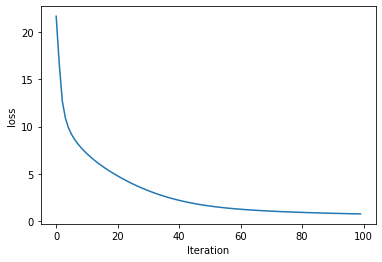

In [19]:
plt.plot(md.losses)
plt.xlabel('Iteration')
plt.ylabel('loss')